In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy 
from scipy import stats,signal
import statsmodels.api as sm

from pyentrp import entropy as ent

import entropy as entro

from scipy.fft import fft, ifft
 

In [89]:
def butter_lowpass(cutoff, nyq_freq, order): ##CORRECT
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order): ##CORRECT
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data) 
    return y


def median_filter(data, f_size): ##CORRECT
    lgth, num_signal = data.shape
    f_data = np.zeros([lgth, num_signal])
    for i in range(num_signal):
        f_data[:,i]=signal.medfilt(data.iloc[:,i], f_size)
    return pd.DataFrame(f_data, columns = ['X','Y','Z'])

def mag(df):
    result = []
    for i in range(df.shape[0]):

        x, y, z = df.iloc[i,:].values
        mag = np.sqrt(x**2 + y**2 + z**2)

        result.append(mag)
    return result


# Fourier Transform
def FFT(x):
#     x = np.asarray(x, dtype=float)
#     N = x.shape[0]
#     n = np.arange(N)
#     k = n.reshape((N, 1))
#     M = np.exp(-2j * np.pi * k * n / N)
#     return np.dot(M, x)
    return np.abs(np.squeeze(fft(x, n = 64 , axis =0)))

In [90]:


# Mean Calculation
def mean(x):
    mean_x = np.mean(x)
    return mean_x

# Standard Deviation Calculation
def std_dev(x):
    std_x = np.std(x)
    return std_x

# Median Absolute Deviation Calculation
def mad(x):
#     mad_x = np.median(np.abs(x - np.median(x)))
    mad_x = np.mean(np.abs(x - np.mean(x)))
    return mad_x
    
# Min Calculation
def min_value(x):
    return min(x)

# Max Calculation
def max_value(x):
    return max(x)

# Signal Magnitude Area Calculation
def sma(signal):
    x,y,z = signal['X'],signal['Y'],signal['Z']
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    abs_z = np.absolute(z)
    return np.mean(abs_x + abs_y + abs_z)

#one Column
def sma2(signal):
    abs_ = np.absolute(signal)
    return np.mean(abs_)


# Energy measure. Sum of the squares divided by the number of values. 
def energy_measure(x):
    em_x = np.mean(np.square(x))
    em_x = np.sum(np.square(x))
    
    return em_x

# Inter-quartile range Calculation
def inter_quartile_range(x):
    iqr_x = np.subtract(*np.percentile(x, [75, 25]))
    return iqr_x



# entropy(): Signal entropy
def entropy(x):
    entr = ent.sample_entropy(x, 1)
#     entr = entro.spectral_entropy(x,  normalize = True)
    
    return entr


# arCoeff(): Autorregresion coefficients with Burg order equal to 4
def arCoeff(signal,order):
    _, sigma = sm.regression.linear_model.burg(signal, order=order)
    return sigma

# correlation(): correlation coefficient between two signals
def coor(signal):
    corr = signal.corr()
    x_y = corr.loc['X','Y']
    x_z = corr.loc['X','Z']
    y_z = corr.loc['Y','Z']
    
    return x_y, x_z, y_z


# maxInds(): index of the frequency component with largest magnitude
def maxInds(x):
    idx_x = np.argmax(x)
    return idx_x


# meanFreq(): Weighted average of the frequency components to obtain a mean frequency
def meanFreq(signal):
    return np.mean(signal)


# skewness(): skewness of the frequency domain signal 
def skewness(x):
    skew_x=stats.skew(x)
    return skew_x

# kurtosis(): kurtosis of the frequency domain signal 
def kurtosis(x):
    kurt_x = stats.kurtosis(x,fisher=False)
    return kurt_x
    

# bandsEnergy(): Energy of a frequency interval within the 64 bins of the FFT of each window.
def bandpower(x, fmin, fmax, fs=1):
#     f, Pxx = scipy.signal.periodogram(x,fs=fs)
#     ind_min = np.argmax(f > fmin) - 1
#     ind_max = np.argmax(f > fmax) - 1
#     return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])
    y = np.sum(x[fmin:fmax] * np.conj(x[fmin:fmax]))
    return y

# angle(): Angle between to vectors.
def angle_calc(vector_1,vector_2):
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle

def angle(signal):
    g = 9.80665
    try:
        l = [g for _ in range(signal.shape[0])] 
    except:
        l = g
    
    angle_value = angle_calc(signal, l)

    return angle_value


In [91]:
def main(gryo,acc):
    sample_rate = 50
    signal_length = 2.56 * sample_rate  # 2.56 seconds
    cutoff_frequency = 20.0  # 20Hz
    col = ['X','Y', 'Z']


    tGyro = pd.DataFrame(columns=['X','Y','Z'])
    tAcc = pd.DataFrame(columns=['X','Y','Z'])


    med_gryo = median_filter(gryo,3)
    med_acc = median_filter(acc,3)


    for i in col:
        tGyro[i] = butter_lowpass_filter(med_gryo[i], cutoff_frequency, sample_rate/2, 3)
        tAcc[i] = butter_lowpass_filter(med_acc[i], cutoff_frequency, sample_rate/2, 3)

    tBodyGyro = tGyro


    tGravityAcc = pd.DataFrame(columns=['X','Y','Z'])
    tBodyAcc = pd.DataFrame(columns=['X','Y','Z'])

    tBodyAccJerk = pd.DataFrame(columns=['X','Y','Z'])
    tBodyGyroJerk = pd.DataFrame(columns=['X','Y','Z'])


    for i in col:
        tGravityAcc[i] = butter_lowpass_filter(tAcc[i], 0.3, sample_rate/2, 3)
#         tBodyAcc[i] = tAcc[i] - tGravityAcc[i] 
        tBodyAcc[i] = tAcc[i] - tGravityAcc[i] 


        #Derivative
        tBodyAccJerk[i] = tBodyAcc[i].diff()
        tBodyGyroJerk[i] = tBodyGyro[i].diff()


    tBodyAccJerk.fillna(0, inplace = True)
    tBodyGyroJerk.fillna(0, inplace = True)


    # Magnitude
    tBodyAccMag = pd.DataFrame(columns=['tBodyAccMag'])
    tBodyAccMag['tBodyAccMag'] =  mag(tBodyAcc)

    tGravityAccMag = pd.DataFrame(columns=['tGravityAccMag'])
    tGravityAccMag['tGravityAccMag'] = mag(tGravityAcc)

    tBodyAccJerkMag = pd.DataFrame(columns=['tBodyAccJerkMag'])
    tBodyAccJerkMag['tBodyAccJerkMag'] = mag(tBodyAccJerk)

    tBodyGyroMag = pd.DataFrame(columns=['tBodyGyroMag'])
    tBodyGyroMag['tBodyGyroMag'] = mag(tBodyGyro)

    tBodyGyroJerkMag = pd.DataFrame(columns=['tBodyGyroJerkMag'])
    tBodyGyroJerkMag['tBodyGyroJerkMag'] = mag(tBodyGyroJerk)

    #CHECKED


    # Fourier Transform
    fBodyAcc= pd.DataFrame(columns=['X','Y','Z'])
    fBodyAccJerk = pd.DataFrame(columns=['X','Y','Z'])
    fBodyGyro = pd.DataFrame(columns=['X','Y','Z'])

    for i in col:
        fBodyAcc[i] = FFT(tBodyAcc[[i]])
        fBodyAccJerk[i] = FFT(tBodyAccJerk[[i]])    
        fBodyGyro[i] = FFT(tBodyGyro[[i]])    

    fBodyAccMag = pd.DataFrame(columns=['fBodyAccMag'])
    fBodyAccMag['fBodyAccMag'] = np.squeeze(FFT(tBodyAccMag))  

    fBodyAccJerkMag = pd.DataFrame(columns=['fBodyAccJerkMag'])
    fBodyAccJerkMag['fBodyAccJerkMag'] = np.squeeze(FFT(tBodyAccJerkMag))    

    fBodyGyroMag = pd.DataFrame(columns=['fBodyGyroMag'])
    fBodyGyroMag['fBodyGyroMag'] = np.squeeze(FFT(tBodyGyroMag))  

    fBodyGyroJerkMag = pd.DataFrame(columns=['fBodyGyroJerkMag'])
    fBodyGyroJerkMag['fBodyGyroJerkMag'] = np.squeeze(FFT(tBodyGyroJerkMag)) 
    
    
    return tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
           tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
           fBodyAcc, fBodyAccJerk, fBodyGyro, \
           fBodyAccMag,fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag
            
            

# Feature Collections

In [92]:
def feature_40(signal, name):
    l = [ 'mean_X', 'mean_Y', 'mean_Z',
         'std_X','std_Y', 'std_Z',
         'mad_X','mad_Y', 'mad_Z',
         'max_X','max_Y', 'max_Z',
         'min_X','min_Y', 'min_Z',
         'sma',
         'energy_X', 'energy_Y','energy_Z',
         'iqr_X','iqr_Y','iqr_Z',
         'entropy_X', 'entropy_Y', 'entropy_Z',
         'X_1','X_2','X_3','X_4','Y_1','Y_2','Y_3','Y_4', 'Z_1','Z_2','Z_3','Z_4',
         'correlation_x_y','correlation_x_z', 'correlation_y_z'
         ]
    col = ['X','Y','Z']
    fet_40 = dict()
    
    for i in col:
        fet_40['mean_' + i ] = mean(signal[i])
        fet_40['std_' + i ] = std_dev(signal[i])
        fet_40['mad_' + i ] = mad(signal[i])
        fet_40['max_' + i ] = max_value(signal[i])
        fet_40['min_' + i ] = min_value(signal[i])
        fet_40['energy_' + i ] = energy_measure(signal[i])
        fet_40['iqr_' + i ] = inter_quartile_range(signal[i])
        fet_40['entropy_' + i ] = entropy(signal[i])
        
        for count in range(1,5):
            fet_40[i + '_' + str(count)] = arCoeff(signal[i], count)
        
    fet_40['sma'] = sma(signal)
    fet_40['correlation_x_y'] = coor(signal)[0]
    fet_40['correlation_x_z'] = coor(signal)[1]
    fet_40['correlation_y_z'] = coor(signal)[2]
    
    res = {}
    for key in l:
        res[name+'_'+key] = fet_40[key]
    
    return res

def feature_13(signal, name):
    fet_13 = dict()
    
    fet_13[name + '_mean'] = mean(signal)
    fet_13[name + '_std'] = std_dev(signal)
    fet_13[name + '_mad'] = mad(signal)
    fet_13[name + '_max'] = max_value(signal)
    fet_13[name + '_min'] = min_value(signal)
    fet_13[name + '_sma'] = sma2(signal)
    fet_13[name + '_energy'] = energy_measure(signal)
    fet_13[name + '_iqr'] = inter_quartile_range(signal)
    fet_13[name + '_entropy'] = entropy(signal)
    
    for count in range(1,5):
        fet_13[name + '_AR_' + str(count)] = arCoeff(signal, count)
    
    return fet_13

def feature_80(signal, name):
    l = ['mean_X', 'mean_Y', 'mean_Z',
         'std_X','std_Y', 'std_Z',
         'mad_X','mad_Y', 'mad_Z',
         'max_X','max_Y', 'max_Z',
         'min_X','min_Y', 'min_Z',
         'sma',
         'energy_X', 'energy_Y','energy_Z',
         'iqr_X', 'iqr_Y', 'iqr_Z',
         'entropy_X', 'entropy_Y', 'entropy_Z',
         'maxInds_X', 'maxInds_Y', 'maxInds_Z',
         'meanFreq_X', 'meanFreq_Y', 'meanFreq_Z',
         'skewness_X', 'kurtosis_X', 'skewness_Y', 'kurtosis_Y', 'skewness_Z', 'kurtosis_Z',
         'bandpower_X-1-8', 'bandpower_X-9-16', 'bandpower_X-17-24', 'bandpower_X-25-32', 'bandpower_X-33-40', 
         'bandpower_X-41-48', 'bandpower_X-49-56', 'bandpower_X-57-64', 
         'bandpower_X-1-16', 'bandpower_X-17-32', 'bandpower_X-33-48', 'bandpower_X-49-64',
         'bandpower_X-1-24', 'bandpower_X-25-48',
         
         'bandpower_Y-1-8', 'bandpower_Y-9-16', 'bandpower_Y-17-24', 'bandpower_Y-25-32', 'bandpower_Y-33-40', 
         'bandpower_Y-41-48', 'bandpower_Y-49-56', 'bandpower_Y-57-64', 
         'bandpower_Y-1-16', 'bandpower_Y-17-32', 'bandpower_Y-33-48', 'bandpower_Y-49-64', 
         'bandpower_Y-1-24', 'bandpower_Y-25-48',
         
         'bandpower_Z-1-8', 'bandpower_Z-9-16', 'bandpower_Z-17-24', 'bandpower_Z-25-32', 'bandpower_Z-33-40', 
         'bandpower_Z-41-48', 'bandpower_Z-49-56', 'bandpower_Z-57-64', 
         'bandpower_Z-1-16', 'bandpower_Z-17-32', 'bandpower_Z-33-48', 'bandpower_Z-49-64', 
         'bandpower_Z-1-24', 'bandpower_Z-25-48' 
         ]

    col = ['X','Y','Z']
    fet_80 = dict()
    
    for i in col:
        fet_80['mean_' + i ] = mean(signal[i])
        fet_80['std_' + i ] = std_dev(signal[i])
        fet_80['mad_' + i ] = mad(signal[i])
        fet_80['max_' + i ] = max_value(signal[i])
        fet_80['min_' + i ] = min_value(signal[i])
        fet_80['energy_' + i ] = energy_measure(signal[i])
        fet_80['iqr_' + i ] = inter_quartile_range(signal[i])
        fet_80['entropy_' + i ] = entropy(signal[i])
        
        fet_80['maxInds_' + i ] = maxInds(signal[i])
        fet_80['meanFreq_' + i ] = meanFreq(signal[i])
        
        fet_80['skewness_' + i] = skewness(signal[i])
        fet_80['kurtosis_' + i] = kurtosis(signal[i])
        

        for j in range(1,65,8):
            fet_80['bandpower_' + i + '-' + str(j) + '-' + str(j+7) ] = bandpower(signal[i], j, j+7)
            
        for k in range(1,65,16):
            fet_80['bandpower_' + i + '-' + str(k) + '-' + str(k+15) ] = bandpower(signal[i], k, k+15)

        for q in range(1,65,24):
            if q+23 > 65:break
            fet_80['bandpower_' + i + '-' + str(q) + '-' + str(q+23)] = bandpower(signal[i], q, q+23) 
        
        
    fet_80['sma'] = sma(signal)

    
    res = {}
    for key in l:
        res[name+'_'+key] = fet_80[key]
    
    return res

def feature_13_MAG(signal, name):
    fet_mag = dict()
    
    fet_mag[name + '_mean'] = mean(signal)
    fet_mag[name + '_std'] = std_dev(signal)
    fet_mag[name + '_mad'] = mad(signal)
    fet_mag[name + '_max'] = max_value(signal)
    fet_mag[name + '_min'] = min_value(signal)
    fet_mag[name + '_sma'] = sma2(signal)
    fet_mag[name + '_energy'] = energy_measure(signal)
    fet_mag[name + '_iqr'] = inter_quartile_range(signal)
    fet_mag[name + '_entropy'] = entropy(signal)
    
    fet_mag[name + '_maxInds' ] = maxInds(signal)
    fet_mag[name + '_meanFreq'] = meanFreq(signal)
    fet_mag[name + '_skewness'] = skewness(signal)
    fet_mag[name + '_kurtosis'] = kurtosis(signal)    
    
    return fet_mag

def last_features():
    feat = dict()
    
    feat['tBodyAccMean_angle'] = angle(tBodyAcc.mean())
    feat['tBodyAccJerkMean_angle'] = angle(tBodyAccJerk.mean())
    feat['tBodyGyroMean_angle'] = angle(tBodyGyro.mean())
    feat['tBodyGyroJerkMean_angle'] = angle(tBodyGyroJerk.mean())
    
    feat['tGravityAcc_X_angle'] = angle(tGravityAcc['X'])
    feat['tGravityAcc_Y_angle'] = angle(tGravityAcc['Y'])
    feat['tGravityAcc_Z_angle'] = angle(tGravityAcc['Z'])

    return feat  

In [93]:
def collectFeatures():
    res = dict()
    
    feat40 = {'tBodyAcc':tBodyAcc,'tGravityAcc': tGravityAcc,'tBodyAccJerk':tBodyAccJerk,
              'tBodyGyro':tBodyGyro,'tBodyGyroJerk': tBodyGyroJerk} 
    for k,v in feat40.items():
        res.update(feature_40(v,k ))
    
    
    
    feat13 = {'tBodyAccMag': tBodyAccMag,'tGravityAccMag': tGravityAccMag,
              'tBodyAccJerkMag': tBodyAccJerkMag,'tBodyGyroMag': tBodyGyroMag,
              'tBodyGyroJerkMag':tBodyGyroJerkMag}
    for k,v in feat13.items():
        res.update(feature_13(v[k],k ))
    
    
    
    feat_80 = {'fBodyAcc': fBodyAcc, 'fBodyAccJerk': fBodyAccJerk, 'fBodyGyro': fBodyGyro}
    for k,v in feat_80.items():
        res.update(feature_80(v,k ))
    
    
    
    feat13_mag = {'fBodyAccMag':fBodyAccMag,'fBodyAccJerkMag': fBodyAccJerkMag,
                  'fBodyGyroMag': fBodyGyroMag, 'fBodyGyroJerkMag': fBodyGyroJerkMag}
    for k,v in feat13_mag.items():
        res.update(feature_13_MAG(v[k],k ))
    
    res.update(last_features())
  
    return res

In [94]:
col_DF = pd.read_csv('test_data.csv').columns

## Walking Up

In [95]:
base_acc = pd.read_csv('Real-Time/walking_up_acc.csv')
base_gryo = pd.read_csv('Real-Time/walking_up_gryo.csv')

print(base_acc.shape, base_gryo.shape)


last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128

for i in range(n):
    gryo = base_gryo.iloc[i*128:(i+1) * 128,:]
    acc = base_acc.iloc[i*128:(i+1) * 128,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)



walking_up = last
walking_up.describe()

(1660, 3) (1660, 3)
(0, 561)


,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

## Walking Down

In [96]:
base_acc = pd.read_csv('Real-Time/walking_down_acc.csv')
base_gryo = pd.read_csv('Real-Time/walking_down_gryo.csv')

print(base_acc.shape, base_gryo.shape)

last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128

for i in range(n):
    gryo = base_gryo.iloc[i*128:(i+1) * 128,:]
    acc = base_acc.iloc[i*128:(i+1) * 128,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)


walking_down = last
print(walking_down.shape)
walking_down.describe()

(1241, 3) (1241, 3)
(0, 561)
(9, 561)


,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

## Walking

In [97]:
base_acc = pd.read_csv('Real-Time/walking_acc.csv')
base_gryo = pd.read_csv('Real-Time/walking_gryo.csv')

print(base_acc.shape, base_gryo.shape)


last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128

for i in range(n):
    gryo = base_gryo.iloc[i*128:(i+1) * 128,:]
    acc = base_acc.iloc[i*128:(i+1) * 128,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)


walking = last
print(walking.shape)
walking.describe()

(1383, 3) (1383, 3)
(0, 561)
(10, 561)


,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

## Sitting

In [98]:
base_acc = pd.read_csv('Real-Time/sitting_acc.csv')
base_gryo = pd.read_csv('Real-Time/sitting_gryo.csv')

print(base_acc.shape, base_gryo.shape)



last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128

for i in range(n):
    gryo = base_gryo.iloc[i*128:(i+1) * 128,:]
    acc = base_acc.iloc[i*128:(i+1) * 128,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)


sitting = last
print(sitting.shape)
sitting.describe()

(1488, 3) (1488, 3)
(0, 561)
(11, 561)


,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

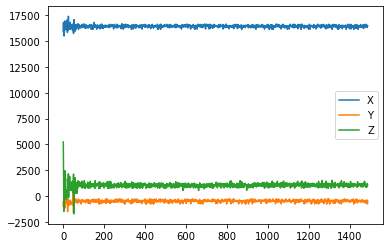

In [124]:
base_acc = pd.read_csv('Real-Time/sitting_acc.csv')
base_gryo = pd.read_csv('Real-Time/sitting_gryo.csv')


base_acc.plot()

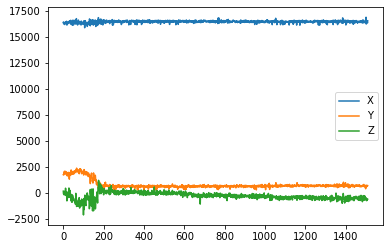

In [125]:
base_acc = pd.read_csv('Real-Time_new/sitting_acc.csv')
base_gryo = pd.read_csv('Real-Time/sitting_gryo.csv')


base_acc.plot()

## Staying

In [99]:
base_acc = pd.read_csv('Real-Time/staying_acc.csv')
base_gryo = pd.read_csv('Real-Time/staying_gryo.csv')

print(base_acc.shape, base_gryo.shape)


last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128

for i in range(n):
    gryo = base_gryo.iloc[i*128:(i+1) * 128,:]
    acc = base_acc.iloc[i*128:(i+1) * 128,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)


staying = last
print(staying.shape)
staying.describe()

(1510, 3) (1510, 3)
(0, 561)
(11, 561)


,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

## Laying

In [100]:
base_acc = pd.read_csv('Real-Time/lying_acc.csv')
base_gryo = pd.read_csv('Real-Time/lying_gryo.csv')

print(base_acc.shape, base_gryo.shape)


last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128

for i in range(n):
    gryo = base_gryo.iloc[i*128:(i+1) * 128,:]
    acc = base_acc.iloc[i*128:(i+1) * 128,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)



lying = last
print(lying.shape)
lying.describe()

(1472, 3) (1472, 3)
(0, 561)
(11, 561)


,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

In [101]:
lying

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

In [102]:
staying

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

In [103]:
# from scipy.signal import periodogram, welch

# def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False,
#                      axis=-1):

#     x = np.asarray(x)
#     # Compute and normalize power spectrum
#     if method == 'fft':
#         _, psd = periodogram(x, sf, axis=axis)
#     elif method == 'welch':
#         _, psd = welch(x, sf, nperseg=nperseg, axis=axis)
#     psd_norm = psd / psd.sum(axis=axis, keepdims=True)
#     se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
#     if normalize:
#         se /= np.log2(psd_norm.shape[axis])
#     return se



In [104]:
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [105]:
X = pd.concat([lying,staying,walking,sitting,walking_down,walking_up],axis = 0)

In [106]:
lay = ['LAYING' for _ in range(lying.shape[0]) ]
s = ['STANDING' for _ in range(staying.shape[0]) ]
w = ['WALKING' for _ in range(walking.shape[0]) ]
sit = ['SITTING' for _ in range(sitting.shape[0]) ]
down = ['WALKING_DOWNSTAIRS' for _ in range(walking_down.shape[0]) ]
up = ['WALKING_UPSTAIRS' for _ in range(walking_up.shape[0]) ]

In [107]:
s = [5 for _ in range(staying.shape[0]) ]
w = [1 for _ in range(walking.shape[0]) ]
sit = [4 for _ in range(sitting.shape[0]) ]
lay = [6 for _ in range(lying.shape[0]) ]
down = [3 for _ in range(walking_down.shape[0]) ]
up = [2 for _ in range(walking_up.shape[0]) ]

In [108]:
Y =  lay +  s + w + sit  + down + up
Y = pd.DataFrame(data = Y,columns=['Label'])

In [109]:
X.to_csv('Real-Time/X.csv', index = None)
Y.to_csv('Real-Time/y.csv', index = None)

In [110]:
X_test = X.copy()

In [111]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range = [-1,1])

X_test  = scaler.fit_transform(X_test)

In [112]:
result = pd.DataFrame(data = X_test, columns= walking_up.columns)

In [113]:
result.to_csv('Real-Time/X_test.csv', index = None)

In [114]:
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:,.5f}'.format


In [115]:
result

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,tBodyAcc_X_1,tBodyAcc_X_2,tBodyAcc_X_3,tBodyAcc_X_4,tBodyAcc_Y_1,tBodyAcc_Y_2,tBodyAcc_Y_3,tBodyAcc_Y_4,tBodyAcc_Z_1,tBodyAcc_Z_2,tBodyAcc_Z_3,tBodyAcc_Z_4,tBodyAcc_correlation_x_y,tBodyAcc_correlation_x_z,tBodyAcc_correlation_y_z,tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,tGravityAcc_X_1,tGravityAcc_X_2,tGravityAcc_X_3,tGravityAcc_X_4,tGravityAcc_Y_1,tGravityAcc_Y_2,tGravityAcc_Y_3,tGravityAcc_Y_4,tGravityAcc_Z_1,tGravityAcc_Z_2,tGravityAcc_Z_3,tGravityAcc_Z_4,tGravityAcc_correlation_x_y,tGravityAcc_correlation_x_z,tGravityAcc_correlation_y_z,tBodyAccJerk_mean_X,tBodyAccJerk_mean_Y,tBodyAccJerk_mean_Z,tBodyAccJerk_std_X,tBodyAccJerk_std_Y,tBodyAccJerk_std_Z,tBodyAccJerk_mad_X,tBodyAccJerk_mad_Y,tBodyAccJerk_mad_Z,tBodyAccJerk_max_X,tBodyAccJerk_max_Y,tBodyAccJerk_max_Z,tBodyAccJerk_min_X,tBodyAccJerk_min_Y,tBodyAccJerk_min_Z,tBodyAccJerk_sma,tBodyAccJerk_energy_X,tBodyAccJerk_energy_Y,tBodyAccJerk_energy_Z,tBodyAccJerk_iqr_X,tBodyAccJerk_iqr_Y,tBodyAccJerk_iqr_Z,tBodyAccJerk_entropy_X,tBodyAccJerk_entropy_Y,tBodyAccJerk_entropy_Z,tBodyAccJerk_X_1,tBodyAccJerk_X_2,tBodyAccJerk_X_3,tBodyAccJerk_X_4,tBodyAccJerk_Y_1,tBodyAccJerk_Y_2,tBodyAccJerk_Y_3,tBodyAccJerk_Y_4,tBodyAccJerk_Z_1,tBodyAccJerk_Z_2,tBodyAccJerk_Z_3,tBodyAccJerk_Z_4,tBodyAccJerk_correlation_x_y,tBodyAccJerk_correlation_x_z,tBodyAccJerk_correlation_y_z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,tBodyGyro_mad_X,tBodyGyro_mad_Y,tBodyGyro_mad_Z,tBodyGyro_max_X,tBodyGyro_max_Y,tBodyGyro_max_Z,tBodyGyro_min_X,tBodyGyro_min_Y,tBodyGyro_min_Z,tBodyGyro_sma,tBodyGyro_energy_X,tBodyGyro_energy_Y,tBodyGyro_energy_Z,tBodyGyro_iqr_X,tBodyGyro_iqr_Y,tBodyGyro_iqr_Z,tBodyGyro_entropy_X,tBodyGyro_entropy_Y,tBodyGyro_entropy_Z,tBodyGyro_X_1,tBodyGyro_X_2,tBodyGyro_X_3,tBodyGyro_X_4,tBodyGyro_Y_1,tBodyGyro_Y_2,tBodyGyro_Y_3,tBodyGyro_Y_4,tBodyGyro_Z_1,tBodyGyro_Z_2,tBodyGyro_Z_3,tBodyGyro_Z_4,tBodyGyro_correlation_x_y,tBodyGyro_correlation_x_z,tBodyGyro_correlation_y_z,tBodyGyroJerk_mean_X,tBodyGyroJerk_mean_Y,tBodyGyroJerk_mean_Z,tBodyGyroJerk_std_X,tBodyGyroJerk_std_Y,tBodyGyroJerk_std_Z,tBodyGyroJerk_mad_X,tBodyGyroJerk_mad_Y,tBodyGyroJerk_mad_Z,tBodyGyroJerk_max_X,tBodyGyroJerk_max_Y,tBodyGyroJerk_max_Z,tBodyGyroJerk_min_X,tBodyGyroJerk_min_Y,tBodyGyroJerk_min_Z,tBodyGyroJerk_sma,tBodyGyroJerk_energy_X,tBodyGyroJerk_energy_Y,tBodyGyroJerk_energy_Z,tBodyGyroJerk_iqr_X,tBodyGyroJerk_iqr_Y,tBodyGyroJerk_iqr_Z,tBodyGyroJerk_entropy_X,tBodyGyroJerk_entropy_Y,tBodyGyroJerk_entropy_Z,tBodyGyroJerk_X_1,tBodyGyroJerk_X_2,tBodyGyroJerk_X_3,tBodyGyroJerk_X_4,tBodyGyroJerk_Y_1,tBodyGyroJerk_Y_2,tBodyGyroJerk_Y_3,tBodyGyroJerk_Y_4,tBodyGyroJerk_Z_1,tBodyGyroJerk_Z_2,tBodyGyroJerk_Z_3,tBodyGyroJerk_Z_4,tBodyGyroJerk_correlation_x_y,tBodyGyroJerk_correlation_x_z,tBodyGyroJerk_correlation_y_z,tBodyAccMag_mean,tBodyAccMag_std,tBodyAccMag_mad,tBodyAccMag_max,tBodyAccMag_min,tBodyAccMag_sma,tBodyAccMag_energy,tBodyAccMag_iqr,tBodyAccMag_entropy,tBodyAccMag_AR_1,tBodyAccMag_AR_2,tBodyAccMag_AR_3,tBodyAccMag_AR_4,tGravityAccMag_mean,tGravityAccMag_std,tGravityAccMag_mad,tGravityAccMag_max,tGravityAccMag_min,tGravityAccMag_sma,tGra

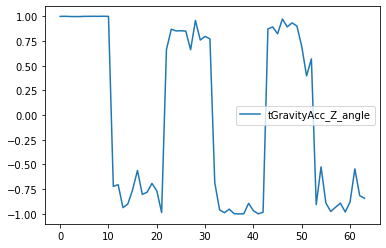

In [116]:
result[['tGravityAcc_Z_angle']].plot()

In [117]:
X.reset_index(inplace = True)

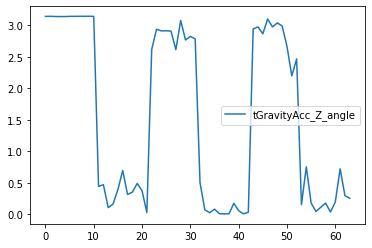

In [118]:
X[['tGravityAcc_Z_angle']].plot()

In [1]:
import pandas as pd

In [28]:
wa_acc = pd.read_csv('Real-Time/walking_up_acc.csv')
wa_gryo = pd.read_csv('Real-Time/walking_up_gryo.csv')

wd_acc = pd.read_csv('Real-Time/walking_down_acc.csv')
wd_gryo = pd.read_csv('Real-Time/walking_down_gryo.csv')


w_acc = pd.read_csv('Real-Time/walking_acc.csv')
w_gryo = pd.read_csv('Real-Time/walking_gryo.csv')


sit_acc = pd.read_csv('Real-Time/sitting_acc.csv')
sit_gryo = pd.read_csv('Real-Time/sitting_gryo.csv')

stay_acc = pd.read_csv('Real-Time/staying_acc.csv')
stay_gryo = pd.read_csv('Real-Time/staying_gryo.csv')


l_acc = pd.read_csv('Real-Time/lying_acc.csv')
l_gryo = pd.read_csv('Real-Time/lying_gryo.csv')

In [29]:
acc = pd.concat([wa_acc, wd_acc, w_acc, sit_acc, stay_acc, l_acc],axis = 0)
gryo = pd.concat([wa_gryo,wd_gryo,w_gryo,sit_gryo,stay_gryo,l_gryo],axis = 0)

In [8]:
acc.to_csv('ACC.csv',index = None)
gryo.to_csv('GRYO.csv',index = None)

In [30]:
uci_acc = pd.read_csv('UCI HAR Dataset/train/InertialSignals/Acc_all.csv',  delimiter = ',')
uci_gryo = pd.read_csv('UCI HAR Dataset/train/InertialSignals/Gyro_all.csv',  delimiter = ',')

In [32]:
uci_acc.describe()

,X,Y,Z
count,941056.000000,941056.000000,941056.000000
mean,0.804749,0.028755,0.086498
std,0.414112,0.390996,0.357769
min,-0.466556,-1.582079,-1.639609
25%,0.664948,-0.220610,-0.131162
50%,0.955993,-0.081328,0.039140
75%,1.019197,0.191284,0.238996
max,2.197618,1.217350,1.281363


In [33]:
acc.describe()

,X,Y,Z
count,8940.000000,8940.000000,8940.000000
mean,7.903717,-1.062153,1.210406
std,3.784486,0.918018,4.122782
min,-0.600000,-5.517251,-16.896917
25%,8.082806,-1.373480,-1.105783
50%,9.494721,-0.822832,0.233300
75%,9.719048,-0.548555,0.797408
max,16.681562,1.850250,16.852649


In [34]:
uci_gryo.describe()

,X,Y,Z
count,941056.000000,941056.000000,941056.000000
mean,0.000506,-0.000824,0.000113
std,0.406815,0.381855,0.255743
min,-4.733656,-5.974330,-2.763014
25%,-0.044328,-0.055065,-0.025253
50%,0.000138,-0.000578,0.000490
75%,0.054847,0.036958,0.049530
max,4.155473,5.746062,2.365982


In [35]:
gryo.describe()

,X,Y,Z
count,8935.000000,8935.000000,8935.000000
mean,0.060392,-0.002872,-0.011733
std,0.296401,0.206226,0.192195
min,-5.004208,-5.004208,-4.712367
25%,-0.016952,-0.023213,-0.067195
50%,0.006109,0.005803,-0.010690
75%,0.079871,0.032376,0.039095
max,5.003444,5.003444,4.232074


In [23]:
uci_x = pd.read_csv('TRAIN_NEW_ALL.csv')
uci_y = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header = None, names = 'Y')[:-1]

uci = pd.concat([uci_x, uci_y], axis = 1)
uci

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,fBodyGyroJerkMag_skewness,fBodyGyroJerkMag_kurtosis,tBodyAccMean_angle,tBodyAccJerkMean_angle,tBodyGyroMean_angle,tBodyGyroJerkMean_angle,tGravityAcc_X_angle,tGravityAcc_Y_angle,tGravityAcc_Z_angle,Y
0,0.002762,0.001315,0.000133,0.010493,0.008834,0.004319,0.007774,0.005349,0.004480,0.025668,...,9.198360,93.962765,0.566773,1.809869,2.107342e-08,1.061327,0.155091,1.691544,1.473941,5
1,-0.000960,-0.000057,-0.000249,0.014228,0.006374,0.006069,0.007747,0.005192,0.005746,0.036188,...,8.868586,89.324705,2.903935,2.836741,0.000000e+00,1.829925,0.152272,1.690155,1.476694,5
2,-0.001182,-0.001555,0.000256,0.013350,0.006191,0.007562,0.011658,0.004112,0.008878,0.034273,...,9.343616,96.008202,2.078138,2.390278,0.000000e+00,1.833364,0.151482,1.692207,1.480654,5
3,0.003515,-0.000345,0.002080,0.009576,0.005429,0.007803,0.007283,0.003915,0.005030,0.036904,...,9.176741,93.681196,0.448147,1.765384,0.000000e+00,1.542461,0.152888,1.697564,1.485789,5
4,0.000977,0.000584,0.000243,0.010571,0.006810,0.007236,0.007801,0.005085,0.006339,0.039929,...,9.741258,101.984925,0.670188,1.665326,0.000000e+00,2.276487,0.151265,1.697314,1.488327,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,-0.092242,0.082714,-0.013205,0.459391,0.716835,0.320620,0.486821,0.660463,0.390400,0.942973,...,8.240620,79.391225,2.577486,2.724614,1.490116e-08,1.288426,0.198164,1.760549,1.627230,2
7347,0.128465,-0.049791,-0.078142,0.454463,0.740316,0.371275,0.353230,0.637055,0.289155,1.363386,...,7.630324,70.598494,0.469514,2.676243,2.107342e-08,2.917188,0.232263,1.792639,1.638456,2
7348,0.007473,-0.125451,-0.097578,0.377887,0.740710,0.376049,0.471966,0.801078,0.279806,0.766242,...,7.948073,74.956062,1.316375,1.261060,0.000000e+00,3.029422,0.225922,1.789062,1.628188,2
7349,-0.007867,-0.056524,-0.044575,0.383426,0.788987,0.323274,0.439328,0.725917,0.245263,0.642362,...,7.744933,71.005200,1.501186,0.833975,2.107342e-08,0.979210,0.218360,1.788873,1.581735,2


In [26]:
uci.describe()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,fBodyGyroJerkMag_skewness,fBodyGyroJerkMag_kurtosis,tBodyAccMean_angle,tBodyAccJerkMean_angle,tBodyGyroMean_angle,tBodyGyroJerkMean_angle,tGravityAcc_X_angle,tGravityAcc_Y_angle,tGravityAcc_Z_angle,Y
count,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,...,7351.000000,7351.000000,7351.000000,7351.000000,7.351000e+03,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000
mean,-0.000150,-0.001601,-0.000147,0.202970,0.223631,0.153608,0.200896,0.210422,0.150144,0.454107,...,8.632828,85.383333,1.582118,1.565673,5.367775e-09,1.780558,0.506862,1.517119,1.468880,3.643586
std,0.058210,0.061384,0.043419,0.221502,0.258219,0.169867,0.230284,0.246818,0.176321,0.506952,...,1.131406,16.372513,0.715218,0.741487,9.073380e-09,0.717518,0.504421,0.424777,0.384132,1.744815
min,-0.404648,-0.561883,-0.336567,0.001441,0.001597,0.001691,0.001186,0.001525,0.001552,0.002692,...,2.481329,8.934065,0.021879,0.025438,0.000000e+00,0.025768,0.001995,0.006675,0.192465,1.000000
25%,-0.007024,-0.007095,-0.004845,0.009161,0.011055,0.006421,0.007712,0.009040,0.005592,0.021598,...,8.101928,76.944395,1.051126,1.001049,0.000000e+00,1.349111,0.187713,1.406252,1.349424,2.000000
50%,0.000015,-0.000122,-0.000084,0.062231,0.053528,0.035903,0.043226,0.038111,0.025372,0.154526,...,8.831727,88.336955,1.589971,1.575278,0.000000e+00,1.786076,0.290509,1.692513,1.551211,4.000000
75%,0.006040,0.005589,0.004211,0.385720,0.395533,0.301502,0.379826,0.382327,0.292683,0.833383,...,9.452319,97.679196,2.127166,2.135127,1.490116e-08,2.324741,0.493091,1.786842,1.695000,5.000000
max,0.439607,0.531722,0.329151,1.316025,1.360262,0.833170,1.564866,1.486995,1.138992,3.616513,...,10.528304,113.449448,3.130889,3.129838,2.107342e-08,3.138335,1.973478,2.097805,2.917969,6.000000


In [27]:
real.describe()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,fBodyGyroJerkMag_skewness,fBodyGyroJerkMag_kurtosis,tBodyAccMean_angle,tBodyAccJerkMean_angle,tBodyGyroMean_angle,tBodyGyroJerkMean_angle,tGravityAcc_X_angle,tGravityAcc_Y_angle,tGravityAcc_Z_angle,Label
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,6.100000e+01,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.001410,0.002929,0.003946,0.141343,0.106930,0.116981,0.131770,0.096309,0.101945,0.340217,...,9.004089,90.954279,1.684152,1.546119,5.862752e-09,1.514118,0.407665,1.681276,1.369503,3.459016
std,0.040494,0.032249,0.023645,0.133543,0.095644,0.085971,0.126237,0.088882,0.075026,0.328732,...,0.857026,12.501586,0.655467,0.699510,7.339831e-09,0.762707,0.536748,0.074147,0.593441,1.727945
min,-0.102140,-0.064739,-0.060291,0.003850,0.008552,0.011648,0.003180,0.006454,0.011572,0.009064,...,5.639303,43.947032,0.309980,0.153094,0.000000e+00,0.130755,0.072963,1.552995,0.053348,1.000000
25%,-0.007205,-0.007997,-0.006280,0.014695,0.013558,0.035743,0.012600,0.011949,0.033784,0.034830,...,8.503366,84.043942,1.158309,1.022209,0.000000e+00,0.880009,0.114880,1.633215,1.491197,2.000000
50%,-0.000276,-0.000868,-0.000140,0.168563,0.112726,0.123764,0.141548,0.093448,0.093543,0.354497,...,9.106857,92.630456,1.681662,1.504219,0.000000e+00,1.610685,0.194307,1.657620,1.575616,3.000000
75%,0.005024,0.008750,0.014372,0.243034,0.181911,0.192247,0.228682,0.169718,0.164202,0.554256,...,9.651100,100.456296,2.138161,1.994110,1.490116e-08,2.077068,0.290269,1.695935,1.655713,5.000000
max,0.155551,0.124381,0.070116,0.393461,0.279180,0.282668,0.381846,0.268395,0.309331,0.988342,...,10.197633,108.652051,2.910093,2.852314,1.490116e-08,2.969161,1.603412,1.891964,1.849304,6.000000


In [25]:
real_x = pd.read_csv('Real-Time/X.csv')
real_y = pd.read_csv('Real-Time/Y.csv')
real = pd.concat([real_x, real_y], axis = 1)
real

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,fBodyGyroJerkMag_skewness,fBodyGyroJerkMag_kurtosis,tBodyAccMean_angle,tBodyAccJerkMean_angle,tBodyGyroMean_angle,tBodyGyroJerkMean_angle,tGravityAcc_X_angle,tGravityAcc_Y_angle,tGravityAcc_Z_angle,Label
0,0.096226,0.102011,0.001972,0.312647,0.218313,0.203108,0.288408,0.200909,0.174804,0.837936,...,8.388970,81.360384,0.947982,2.474847,0.000000e+00,0.130755,0.142940,1.701767,1.627728,1
1,-0.038495,-0.015664,0.070116,0.329495,0.160286,0.238872,0.303838,0.169718,0.187380,0.536950,...,8.474671,82.902495,2.041801,0.196006,1.490116e-08,2.546050,0.236901,1.803166,1.616077,1
2,-0.087141,0.017775,-0.017271,0.348929,0.165695,0.193870,0.352462,0.140195,0.158814,0.530209,...,8.624770,84.715521,2.910093,1.171537,0.000000e+00,0.821531,0.255802,1.824263,1.604546,1
3,-0.062121,0.026599,0.065301,0.380756,0.167221,0.266236,0.381846,0.152884,0.249550,0.736551,...,7.989105,75.617038,2.451849,2.796797,0.000000e+00,2.062546,0.256462,1.808658,1.664872,1
4,0.155551,-0.020876,-0.060291,0.393461,0.213265,0.203578,0.367602,0.191090,0.169724,0.918327,...,7.983116,75.110757,0.309980,2.462290,0.000000e+00,0.979948,0.279208,1.836117,1.655713,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.004641,-0.001701,-0.001118,0.023288,0.009477,0.013330,0.019295,0.008149,0.013107,0.064125,...,9.873350,103.948421,1.802473,1.481726,0.000000e+00,1.984951,1.603412,1.631192,0.068659,6
57,0.004169,-0.013391,-0.020130,0.022799,0.018887,0.029447,0.014128,0.012440,0.018549,0.071417,...,9.050777,92.245046,2.491949,0.695491,0.000000e+00,1.333266,1.598068,1.621177,0.057299,6
58,-0.001110,-0.002150,-0.008835,0.018084,0.008711,0.015562,0.020484,0.006959,0.011969,0.042380,...,9.697762,101.098177,2.816616,0.802289,1.490116e-08,1.935186,1.598661,1.621246,0.057645,6
59,-0.002331,-0.000723,-0.002187,0.021039,0.008976,0.011648,0.021399,0.009203,0.011572,0.051897,...,9.739553,101.837912,2.259330,1.500502,0.000000e+00,0.162321,1.598799,1.620422,0.056992,6
